In [1]:
import warnings

import matplotlib
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split

from util import *
from setup_r import *

warnings.filterwarnings("ignore")

25/03/26 09:12:21 WARN Utils: Your hostname, madhav-ThinkPad-P16-Gen-2 resolves to a loopback address: 127.0.1.1; using 192.168.1.14 instead (on interface wlp0s20f3)
25/03/26 09:12:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/26 09:12:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = load_data("pbc.csv")
print(df.shape)
print(f"First 5 columns of DataFrame:\n{df.head()}")

(258, 19)
First 5 columns of DataFrame:
        time  status  trt        age  sex  ascites  hepato  spiders  edema  \
0   1.095890     1.0    0  58.765229  0.0        1       1        1    1.0   
1  12.328767     0.0    0  56.446270  0.0        0       1        1    0.0   
2   2.772603     1.0    0  70.072553  1.0        0       0        0    0.5   
3   5.273973     1.0    0  54.740589  0.0        0       1        1    0.5   
4   5.019178     0.0    1  55.534565  0.0        0       1        0    0.0   

   bili  chol  albumin  copper  alk_phos     ast  trig  platelet  protime  \
0  14.5   261     2.60     156    1718.0  137.95   172       190     12.2   
1   1.1   302     4.14      54    7394.8  113.52    88       221     10.6   
2   1.4   176     3.48     210     516.0   96.10    55       151     12.0   
3   1.8   244     2.54      64    6121.8   60.63    92       183     10.3   
4   1.0   322     4.09      52     824.0   60.45   213       204      9.7   

   stage  
0      4  
1     

In [3]:
df_dev, df_test = train_test_split(df, test_size=0.2)
df_train, df_val = train_test_split(df_dev, test_size=0.25)

print("\nTotal number of patients:", df.shape[0])
print("Total number of patients in training set:", df_train.shape[0])
print("Total number of patients in validation set:", df_val.shape[0])
print("Total number of patients in test set:", df_test.shape[0])


Total number of patients: 258
Total number of patients in training set: 154
Total number of patients in validation set: 52
Total number of patients in test set: 52


In [4]:
continuous_columns = [
    "age",
    "bili",
    "chol",
    "albumin",
    "copper",
    "alk_phos",
    "ast",
    "trig",
    "platelet",
    "protime",
]

In [5]:
df_train.loc[:, continuous_columns] = df_train.loc[:, continuous_columns].astype(
    float
)

df_val.loc[:, continuous_columns] = df_val.loc[:, continuous_columns].astype(float)

df_test.loc[:, continuous_columns] = df_test.loc[:, continuous_columns].astype(
    float
)

mean = df_train.loc[:, continuous_columns].mean()
std = df_train.loc[:, continuous_columns].std()
df_train.loc[:, continuous_columns] = (
    df_train.loc[:, continuous_columns] - mean
) / std

df_val.loc[:, continuous_columns] = (df_val.loc[:, continuous_columns] - mean) / std
df_test.loc[:, continuous_columns] = (
    df_test.loc[:, continuous_columns] - mean
) / std

In [6]:
to_encode = ["edema", "stage"]

one_hot_train = to_one_hot(df_train, to_encode)
one_hot_val = to_one_hot(df_val, to_encode)
one_hot_test = to_one_hot(df_test, to_encode)
print(one_hot_val.columns.tolist())
print(f"There are {len(one_hot_val.columns)} columns")
print(one_hot_train.shape)
print(one_hot_train.head())

['time', 'status', 'trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'bili', 'chol', 'albumin', 'copper', 'alk_phos', 'ast', 'trig', 'platelet', 'protime', 'edema_0.5', 'edema_1.0', 'stage_2', 'stage_3', 'stage_4']
There are 22 columns
(154, 22)
         time  status  trt       age  sex  ascites  hepato  spiders      bili  \
184  5.328767     0.0    0 -1.149513  0.0        0       0        0 -0.467658   
10   9.800000     0.0    1 -0.453968  0.0        0       0        0 -0.535815   
73   9.200000     1.0    1 -0.303653  0.0        0       1        0 -0.217748   
46   5.060274     1.0    1 -1.641674  0.0        0       1        1 -0.444939   
32   9.893151     0.0    1  0.600932  0.0        0       0        0 -0.626691   

         chol  ...  alk_phos       ast      trig  platelet   protime  \
184 -0.273030  ... -0.393480  0.621057 -0.330838  0.493515 -0.961985   
10  -0.386999  ... -0.407539 -0.654387  0.085483 -0.214436 -0.117583   
73  -0.464336  ... -0.039468 -0.626044 -0.574888

<lifelines.CoxPHFitter: fitted with 154 total observations, 94 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 154
number of events observed = 60
   partial log-likelihood = -203.38
         time fit was run = 2025-03-26 03:44:34 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
trt       -0.05      0.95      0.34           -0.71            0.61                0.49                1.84
age        0.45      1.57      0.19            0.08            0.82                1.08                2.26
sex        1.00      2.70      0.39            0.23            1.76                1.26                5.80
ascites    1.05      2.85      0.86           -0.63            2.73                0.53               15.30
hepato     0.58      1.78      0.39           -0.19            1.34                0.83                3.80
spiders    0.80      2.23      0.37            0.08            1.53                1.08                4.61
bili      -0.08      0.93      0.24           -0.55            0.40                0.58                1.49
chol       0.11      1.12      0.17           -0.22            0.44                0.80                1.56
albumin   -0.25      0.78      0.18           -0.60            0.10                0.55                1.11
copper     0.49      1.63      0.14            0.22            0.76                1.25                2.13
alk_phos   0.05      1.05      0.13           -0.21            0.31                0.81                1.36
ast        0.53      1.70      0.18            0.17            0.88                1.19                2.42
trig      -0.03      0.98      0.16           -0.34            0.29                0.71                1.34
platelet   0.23      1.26      0.18           -0.11            0.58                0.89                1.79
protime    0.33      1.39      0.21           -0.09            0.75                0.92                2.11
edema_0.5  0.41      1.51      0.55           -0.67            1.50                0.51                4.48
edema_1.0  2.44     11.45      0.95            0.57            4.31                1.76               74.35
stage_2    0.98      2.67      1.19           -1.35            3.31                0.26               27.39
stage_3    1.03      2.79      1.12           -1.18            3.23                0.31               25.16
stage_4    0.95      2.58      1.20           -1.40            3.30                0.25               27.15

           cmp to     z      p  -log2(p)
covariate                               
trt          0.00 -0.15   0.88      0.18
age          0.00  2.39   0.02      5.88
sex          0.00  2.56   0.01      6.56
ascites      0.00  1.22   0.22      2.18
hepato       0.00  1.48   0.14      2.85
spiders      0.00  2.17   0.03      5.06
bili         0.00 -0.31   0.76      0.40
chol         0.00  0.65   0.51      0.96
albumin      0.00 -1.39   0.16      2.61
copper       0.00  3.61 <0.005     11.66
alk_phos     0.00  0.37   0.71      0.49
ast          0.00  2.90 <0.005      8.08
trig         0.00 -0.16   0.88      0.19
platelet     0.00  1.32   0.19      2.42
protime      0.00  1.55   0.12      3.04
edema_0.5    0.00  0.75   0.45      1.14
edema_1.0    0.00  2.55   0.01      6.55
stage_2      0.00  0.82   0.41      1.29
stage_3      0.00  0.91   0.36      1.47
stage_4      0.00  0.79   0.43      1.22
---
Concordance = 0.88
Partial AIC = 446.77
log-likelihood ratio test = 121.04 on 20 df
-log2(p) of ll-ratio test = 52.28

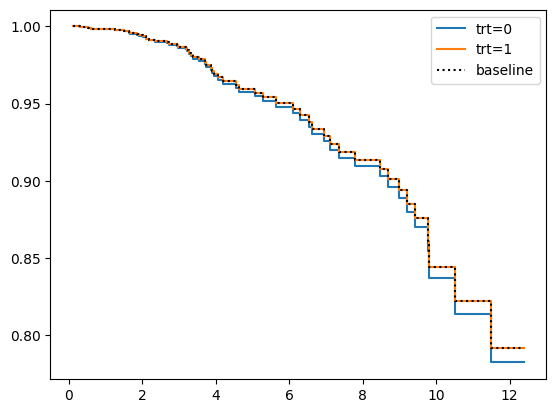

In [ ]:
cph = CoxPHFitter()
cph.fit(
    one_hot_train,
    duration_col="time",
    event_col="status",
    fit_options={"step_size": 0.1},
)

cph.print_summary()
cph.plot_covariate_groups("trt", values=[0, 1])
plt.show()

In [8]:
# Train
scores = cph.predict_partial_hazard(one_hot_train)
cox_train_scores = harrell_c(
    one_hot_train["time"].values, scores.values, one_hot_train["status"].values
)

In [9]:
# Validation
scores = cph.predict_partial_hazard(one_hot_val)
cox_val_scores = harrell_c(
    one_hot_val["time"].values, scores.values, one_hot_val["status"].values
)

In [10]:
# Test
scores = cph.predict_partial_hazard(one_hot_test)
cox_test_scores = harrell_c(
    one_hot_test["time"].values, scores.values, one_hot_test["status"].values
)

In [11]:
print("Train:", cox_train_scores)
print("Val:", cox_val_scores)
print("Test:", cox_test_scores)

Train: 0.8807308408052783
Val: 0.7727272727272727
Test: 0.806831566548881


In [12]:
model = forest.rfsrc(
    ro.Formula("Surv(time, status) ~ ."),
    data=df_train,
    ntree=300,
    nodedepth=5,
    seed=-1,
)

In [13]:
print(f"\nModel summary:\n{model}")


Model summary:
                         Sample size: 154
                    Number of deaths: 60
                     Number of trees: 300
           Forest terminal node size: 15
       Average no. of terminal nodes: 6.6267
No. of variables tried at each split: 5
              Total no. of variables: 17
       Resampling used to grow trees: swor
    Resample size used to grow trees: 97
                            Analysis: RSF
                              Family: surv
                      Splitting rule: logrank *random*
       Number of random split points: 10
                          (OOB) CRPS: 1.37555091
                   (OOB) stand. CRPS: 0.11979864
   (OOB) Requested performance error: 0.16773812




In [14]:
result = R.predict(model, newdata=df_val)
scores = np.array(result.rx("predicted")[0])

print("Cox Model Validation Score:", cox_val_scores)
print(
    "Survival Forest Validation Score:",
    harrell_c(df_val["time"].values, scores, df_val["status"].values),
)

Cox Model Validation Score: 0.7727272727272727
Survival Forest Validation Score: 0.7909090909090909


In [15]:
result = R.predict(model, newdata=df_test)
scores = np.array(result.rx("predicted")[0])

print("Cox Model Test Score:", cox_test_scores)
print(
    "Survival Forest Validation Score:",
    harrell_c(df_test["time"].values, scores, df_test["status"].values),
)

Cox Model Test Score: 0.806831566548881
Survival Forest Validation Score: 0.817432273262662


In [16]:
vimps = np.array(forest.vimp(model).rx("importance")[0])

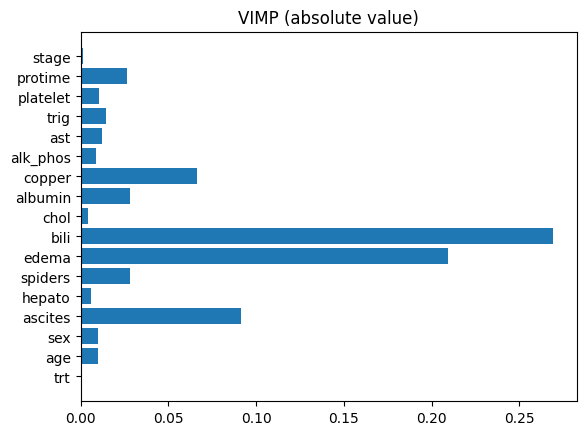

In [17]:
y = np.arange(len(vimps))
plt.barh(y, np.abs(vimps))
plt.yticks(y, df_train.drop(["time", "status"], axis=1).columns)
plt.title("VIMP (absolute value)")
plt.show()